# Alphagenome Batch scoring for 7 different scorers in skeletal muscle tissue

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
from cyvcf2 import VCF
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
import pyranges as pr

In [2]:
MUSCLE_SKELETAL_RESULTS = "/Users/markus/university/ML-in-biotech-CB206V-ws25/data/results/muscle_skeletal_alphagenome_scores_filtered.tsv.gz"
VG_HI = "/Users/markus/university/ML-in-biotech-CB206V-ws25/data/initial/vg_hi.parquet"
EQTL = "/Users/markus/university/ML-in-biotech-CB206V-ws25/data/initial/MUSCLE_SKELETAL.v10.eQTLs.signif_pairs.parquet"
VARIANT_FILE = "/Users/markus/university/ML-in-biotech-CB206V-ws25/data/intermediate/muscle_skeletal/muscle_skeletal_variants_all.tsv.gz" # using this for AF scores


# Overview of results in skeletal musckle AlphaGenome subset

In [3]:
df = pd.read_csv(MUSCLE_SKELETAL_RESULTS, sep="\t")

print(df.shape)
print(df.columns.tolist())

counts = (
    df["variant_scorer"]
    .value_counts()
    .rename_axis("scorer")
    .reset_index(name="count")
)

print(counts)

(1336366, 27)
['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'gtex_tissue', 'raw_score', 'quantile_score', 'scored_interval_str', 'seq_len', 'CHROM', 'POS', 'REF', 'ALT', 'gene_tag', 'scorer_friendly']
                                              scorer   count
0        GeneMaskLFCScorer(requested_output=RNA_SEQ)  371266
1  CenterMaskScorer(requested_output=RNA_SEQ, wid...  160850
2  CenterMaskScorer(requested_output=RNA_SEQ, wid...  160850
3  CenterMaskScorer(requested_output=RNA_SEQ, wid...  160850
4  CenterMaskScorer(requested_output=RNA_SEQ, wid...  160850
5  CenterMaskScorer(requested_output=RNA_SEQ, wid...  160850
6  CenterMaskScorer(requested_output=RNA_SEQ, wid...  160850


* raw_score -> this is the direct score output from the model for a given variant × scorer × tissue.
* For most scorers (like GeneMaskLFCScorer), it’s a model-predicted effect size or log fold change (Δexpression).
* quantile_score -> this is a rank-normalized version of the raw score — roughly placing it into a [0,1] range by comparing it to other scores genome-wide.
* Values near 0.0 → “among the lowest scores”; near 1.0 → “among the highest scores”.

# How strong are the predicted functional effects of regions of different genomic widths?

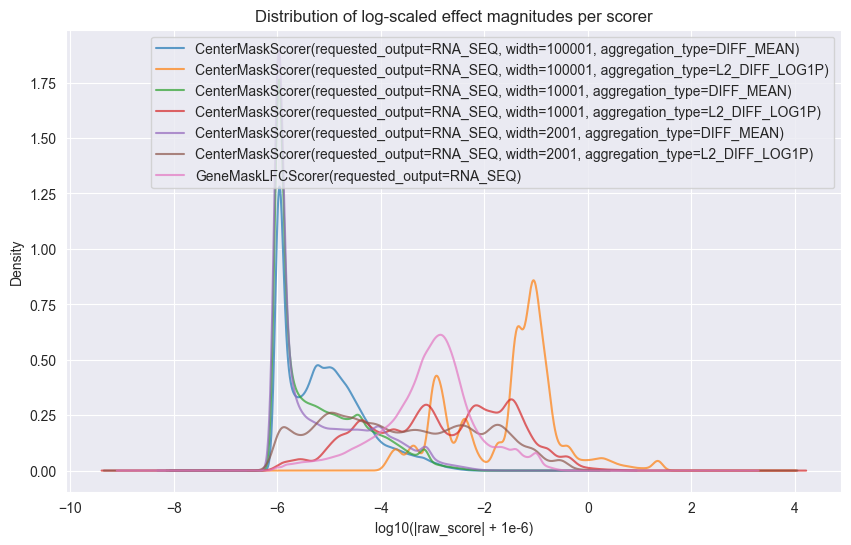

In [4]:
res = pd.read_csv(MUSCLE_SKELETAL_RESULTS, sep="\t", usecols=["variant_scorer","raw_score"])
res["abs_score"] = res["raw_score"].abs()
res["log_abs_score"] = np.log10(res["abs_score"] + 1e-6)

fig, ax = plt.subplots(figsize=(10,6))
for name, g in res.groupby("variant_scorer"):
    g["log_abs_score"].plot(kind="kde", ax=ax, label=name, alpha=0.7)

plt.xlabel("log10(|raw_score| + 1e-6)")
plt.title("Distribution of log-scaled effect magnitudes per scorer")
plt.legend()
plt.show()

For sanity check this plot shows how strong the predicted effects are for different AlphaGenome scorers. The x-axis is on a log scale, so values further to the right mean stronger effects, while values to the left mean smaller or no effects. Each colored line represents a different way of masking parts of the genome or calculating changes. The GeneMaskLFCScorer measures changes on a log fold-change scale, while the CenterMaskScorers measure smaller, local changes in regular units. Narrower masks focus on small regions and tend to show stronger, sharper effects, while wider masks spread the effect out and make it weaker.

 When the whole gene is masked (GeneMaskLFCScorer), the model predicts bigger effects because gene expression is directly disrupted. For the CenterMaskScorers, the effects get smaller as the mask gets larger—from 2 kb to 100 kb—showing that local regions near the gene have more influence than distant ones. The two CenterMask scoring methods (DIFF_MEAN and L2_DIFF_LOG1P) behave similarly, meaning the results are stable regardless of the exact calculation. Overall, this shows that AlphaGenome captures realistic biological behavior: nearby regulatory regions matter most, and broader regions have weaker effects.

Now we basically can choose the best performing scorer and window? We want to see that:
* Most mutations do almost nothing (non-regulatory).
* Moderate local effects (enhancers/promoters) dominate.
* Huge effects are rare (core elements, exons, strong promoters).

Therefore, a biologically realistic scorer should:
* Produce a long-tailed distribution (many small effects, few large).
* Capture local sensitivity (small windows show stronger effects).
* Avoid overly flat or noisy behavior (which suggests over-smoothing or numerical instability).


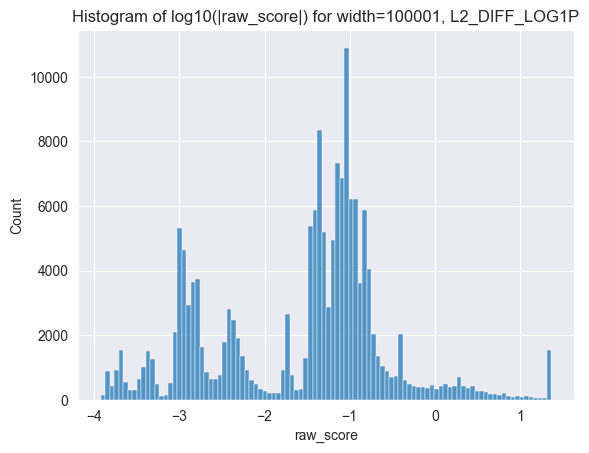

In [5]:
subset = res[res["variant_scorer"].str.contains("width=100001") &
              res["variant_scorer"].str.contains("L2_DIFF_LOG1P")]
sns.histplot(np.log10(subset["raw_score"].abs() + 1e-6), bins=100, kde=False)
plt.title("Histogram of log10(|raw_score|) for width=100001, L2_DIFF_LOG1P")
plt.show()

most mutations do almost nothing, a smaller fraction tweak expression slightly, and only a few have large regulatory impact.

## Checking correlation between AlphaGenome scores and VG.HI

                                            friendly  n_genes  pearson_r  \
0  CenterMaskScorer(requested_output=RNA_SEQ, wid...       15  -0.051158   
1  CenterMaskScorer(requested_output=RNA_SEQ, wid...       15   0.029365   
2  CenterMaskScorer(requested_output=RNA_SEQ, wid...       15   0.020485   
3  CenterMaskScorer(requested_output=RNA_SEQ, wid...       15   0.275661   
4  CenterMaskScorer(requested_output=RNA_SEQ, wid...       15   0.003807   
5  CenterMaskScorer(requested_output=RNA_SEQ, wid...       15   0.018173   
6                           gene_exonmask_delta_log2       52  -0.007867   

   pearson_p  spearman_r  spearman_p  
0   0.856317   -0.064286    0.819948  
1   0.917262    0.025000    0.929529  
2   0.942234   -0.378571    0.164091  
3   0.320002    0.057143    0.839700  
4   0.989257   -0.210714    0.450958  
5   0.948744    0.064286    0.819948  
6   0.955856   -0.208742    0.137521  


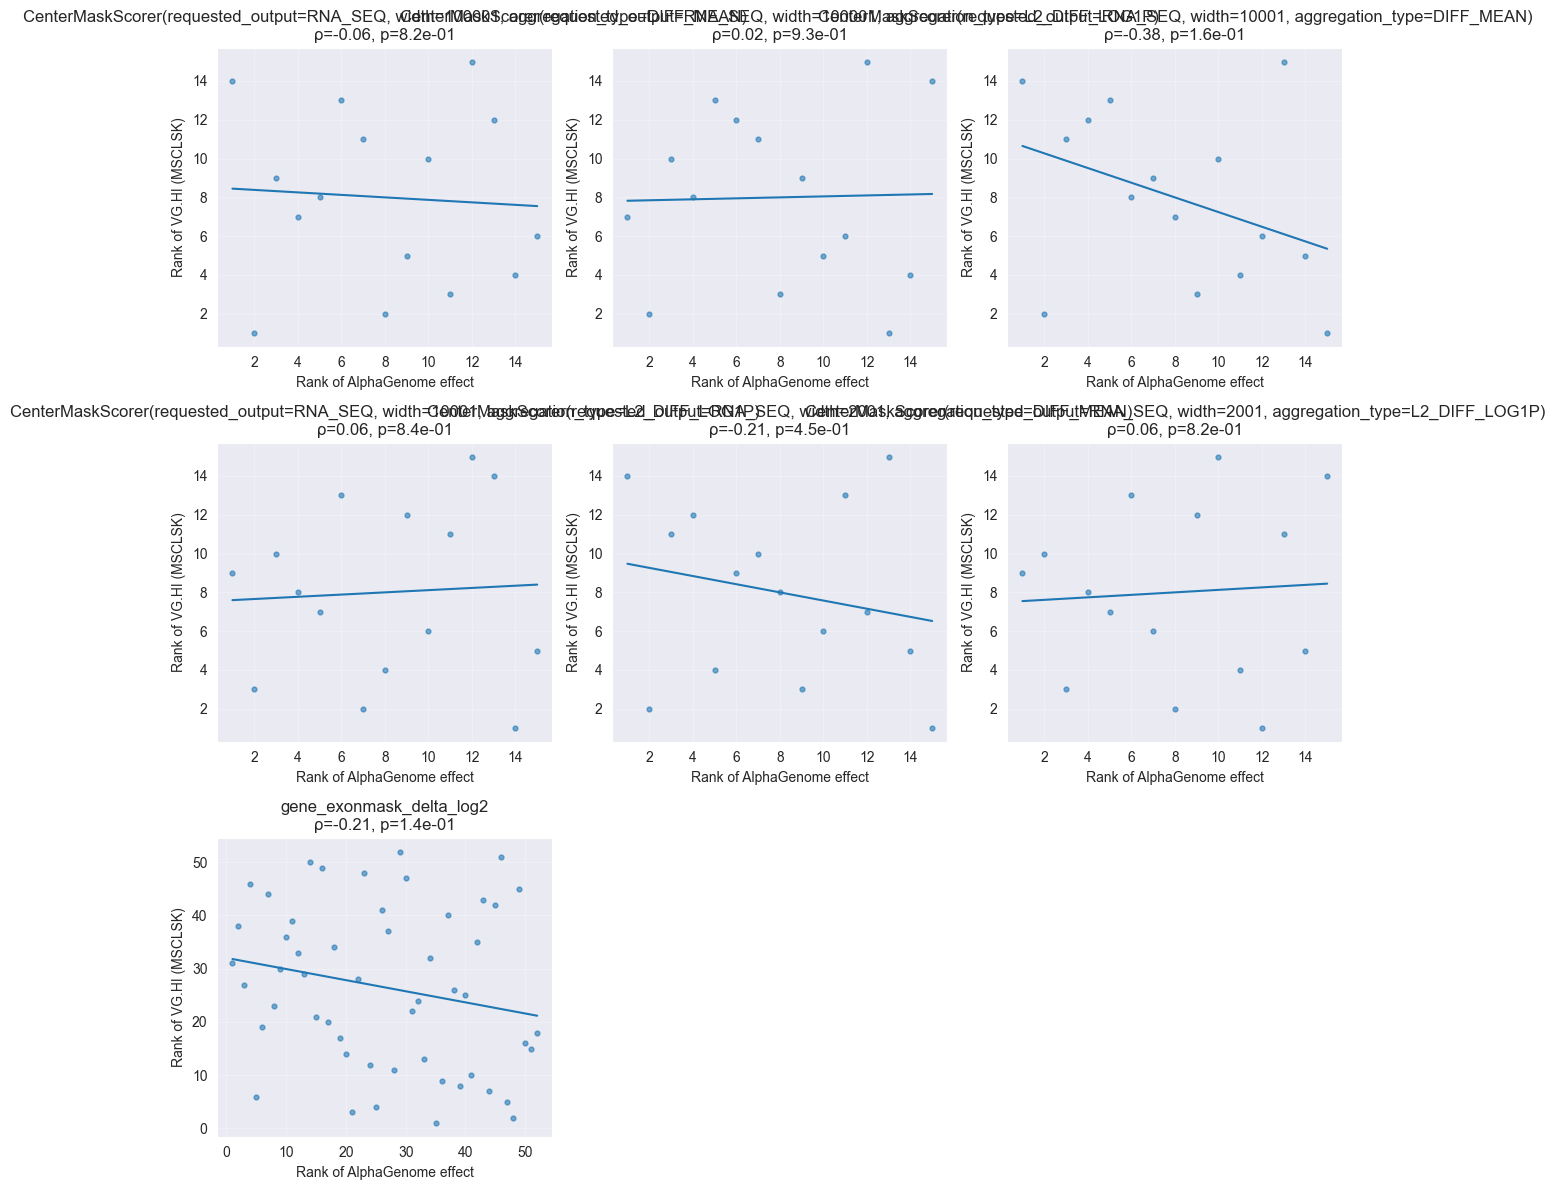

In [6]:
RENAME_FRIENDLY = {
    "GeneMaskLFCScorer": "gene_exonmask_delta_log2",
    "CenterMaskScorer(width=2001).DIFF_MEAN": "center2.001kb_diff_mean",
    "CenterMaskScorer(width=10001).DIFF_MEAN": "center10.001kb_diff_mean",
    "CenterMaskScorer(width=100001).DIFF_MEAN": "center100.001kb_diff_mean",
    "CenterMaskScorer(width=2001).L2_DIFF_LOG1P": "center2.001kb_l2_log1p",
    "CenterMaskScorer(width=10001).L2_DIFF_LOG1P": "center10.001kb_l2_log1p",
    "CenterMaskScorer(width=100001).L2_DIFF_LOG1P": "center100.001kb_l2_log1p",
}

def friendly(name: str) -> str:
    s = str(name)
    for k, v in RENAME_FRIENDLY.items():
        if k in s:
            return v
    return s

def strip_ensg(x: object) -> str | None:
    if x is None or pd.isna(x):
        return None
    m = re.search(r"(ENSG\d+)", str(x))
    return m.group(1) if m else None

res = pd.read_csv(MUSCLE_SKELETAL_RESULTS, sep="\t", compression="infer", low_memory=False)
keep_cols = ["gene_id", "gene_name", "raw_score", "variant_scorer"]
res = res[[c for c in keep_cols if c in res.columns]].copy()

# normalize identifiers
if "gene_id" not in res.columns:
    res["gene_id"] = pd.NA
res["gene_id"] = res["gene_id"].map(strip_ensg).astype("string")
if "gene_name" not in res.columns:
    res["gene_name"] = pd.NA
res["gene_name"] = res["gene_name"].astype("string")
res["variant_scorer"] = res["variant_scorer"].astype("string")

mask_rescue = res["gene_id"].isna() & res["gene_name"].str.contains(r"ENSG\d+", na=False)
res.loc[mask_rescue, "gene_id"] = res.loc[mask_rescue, "gene_name"].map(strip_ensg)

res = res.dropna(subset=["gene_id", "raw_score"]).copy()

vg = pd.read_parquet(VG_HI)

# ensure gene_id column exists
if "gene_id" not in vg.columns:
    vg = vg.reset_index()  # if gene ids are in the index
    if "gene_id" not in vg.columns:
        if "index" in vg.columns:
            vg = vg.rename(columns={"index": "gene_id"})
        else:
            raise KeyError("Could not find or recover 'gene_id' in VG_HI parquet")

# strict requirement: MSCLSK column must exist
if "MSCLSK" not in vg.columns:
    raise KeyError("Expected column 'MSCLSK' not found in VG_HI parquet")

vg["gene_id"] = vg["gene_id"].map(strip_ensg).astype("string")
vg_MUSCLE_SKELETAL = (
    vg.loc[:, ["gene_id", "MSCLSK"]]
      .rename(columns={"MSCLSK": "vg_hi_MSCLSK"})
      .dropna(subset=["gene_id", "vg_hi_MSCLSK"])
)

# --- 3) Correlations per scorer ---
scorer_order = sorted(res["variant_scorer"].dropna().unique().tolist(), key=friendly)
rows, per_scorer = [], {}

for sc in scorer_order:
    sub = res[res["variant_scorer"] == sc].copy()
    if sub.empty:
        continue

    gene_agg = (
        sub.groupby("gene_id", as_index=False)
           .agg(ag_effect=("raw_score", "mean"),
                gene_name=("gene_name", "first"))
    )

    merged = pd.merge(gene_agg, vg_MUSCLE_SKELETAL, on="gene_id", how="inner")
    merged = merged.dropna(subset=["ag_effect", "vg_hi_MSCLSK"])
    if merged.empty:
        continue

    x = merged["ag_effect"].to_numpy()
    y = merged["vg_hi_MSCLSK"].to_numpy()
    pr, pp = pearsonr(x, y)
    sr, sp = spearmanr(x, y)

    rows.append({
        "scorer": sc,
        "friendly": friendly(sc),
        "n_genes": merged.shape[0],
        "pearson_r": pr,
        "pearson_p": pp,
        "spearman_r": sr,
        "spearman_p": sp
    })
    per_scorer[sc] = merged

summary = pd.DataFrame(rows).sort_values("friendly").reset_index(drop=True)
print(summary.loc[:, ["friendly", "n_genes", "pearson_r", "pearson_p", "spearman_r", "spearman_p"]])

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for ax, sc in zip(axes, summary["scorer"]):
    d = per_scorer[sc]
    xr = d["ag_effect"].rank(method="average")
    yr = d["vg_hi_MSCLSK"].rank(method="average")
    sns.regplot(x=xr, y=yr, ax=ax, scatter_kws={"s": 12, "alpha": 0.6}, line_kws={"linewidth": 1.5}, ci=None)
    row = summary[summary["scorer"] == sc].iloc[0]
    ax.set_title(f"{row['friendly']}\nρ={row['spearman_r']:.2f}, p={row['spearman_p']:.1e}")
    ax.set_xlabel("Rank of AlphaGenome effect")
    ax.set_ylabel("Rank of VG.HI (MSCLSK)")
    ax.grid(alpha=0.25)

for j in range(len(summary), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

no correlation here

## EQTL scores

In [7]:
eqtl = pd.read_parquet(EQTL)
print("EQTL shape:", eqtl.shape)
print(eqtl.head())

eqtl_slim = eqtl[["gene_id", "variant_id", "pval_nominal", "slope"]].copy()
eqtl_slim["gene_id"] = eqtl_slim["gene_id"].astype(str)

eqtl_gene = (
    eqtl_slim
    .groupby("gene_id", as_index=False)
    .agg(
        min_pval=("pval_nominal", "min"),
        mean_slope=("slope", "mean"),
        mean_abs_slope=("slope", lambda x: x.abs().mean())
    )
)
eqtl_gene["gene_id"] = eqtl_gene["gene_id"].str.replace(r"\.\d+$", "", regex=True)

print(eqtl_gene.head())

EQTL shape: (3147347, 12)
             gene_id           variant_id  tss_distance        af  ma_samples  \
0  ENSG00000227232.5   chr1_64764_C_T_b38         35211  0.067402         106   
1  ENSG00000227232.5  chr1_625776_T_G_b38        596223  0.137868         209   
2  ENSG00000227232.5  chr1_627983_C_T_b38        598430  0.155025         223   
3  ENSG00000227232.5  chr1_632834_C_T_b38        603281  0.142770         216   
4  ENSG00000227232.5  chr1_634553_G_A_b38        605000  0.158088         232   

   ma_count  pval_nominal     slope  slope_se  pval_nominal_threshold  \
0       110  1.024945e-10  0.520838  0.079432                0.000644   
1       225  1.688817e-05 -0.260128  0.060065                0.000644   
2       253  3.663020e-04 -0.193873  0.054159                0.000644   
3       233  4.159940e-04 -0.210468  0.059359                0.000644   
4       258  2.294824e-04 -0.205121  0.055405                0.000644   

   min_pval_nominal     pval_beta  
0      1.024

                                            friendly  n_genes  pearson_r  \
0  CenterMaskScorer(requested_output=RNA_SEQ, wid...       10  -0.035667   
1  CenterMaskScorer(requested_output=RNA_SEQ, wid...       10   0.020888   
2  CenterMaskScorer(requested_output=RNA_SEQ, wid...       10   0.116672   
3  CenterMaskScorer(requested_output=RNA_SEQ, wid...       10   0.373096   
4  CenterMaskScorer(requested_output=RNA_SEQ, wid...       10   0.171991   
5  CenterMaskScorer(requested_output=RNA_SEQ, wid...       10   0.266284   
6                           gene_exonmask_delta_log2       27  -0.009325   

   pearson_p  spearman_r  spearman_p  
0   0.922078    0.103030    0.776998  
1   0.954327    0.721212    0.018573  
2   0.748226    0.406061    0.244282  
3   0.288287    0.272727    0.445838  
4   0.634704    0.272727    0.445838  
5   0.457079    0.224242    0.533401  
6   0.963180   -0.128816    0.521945  


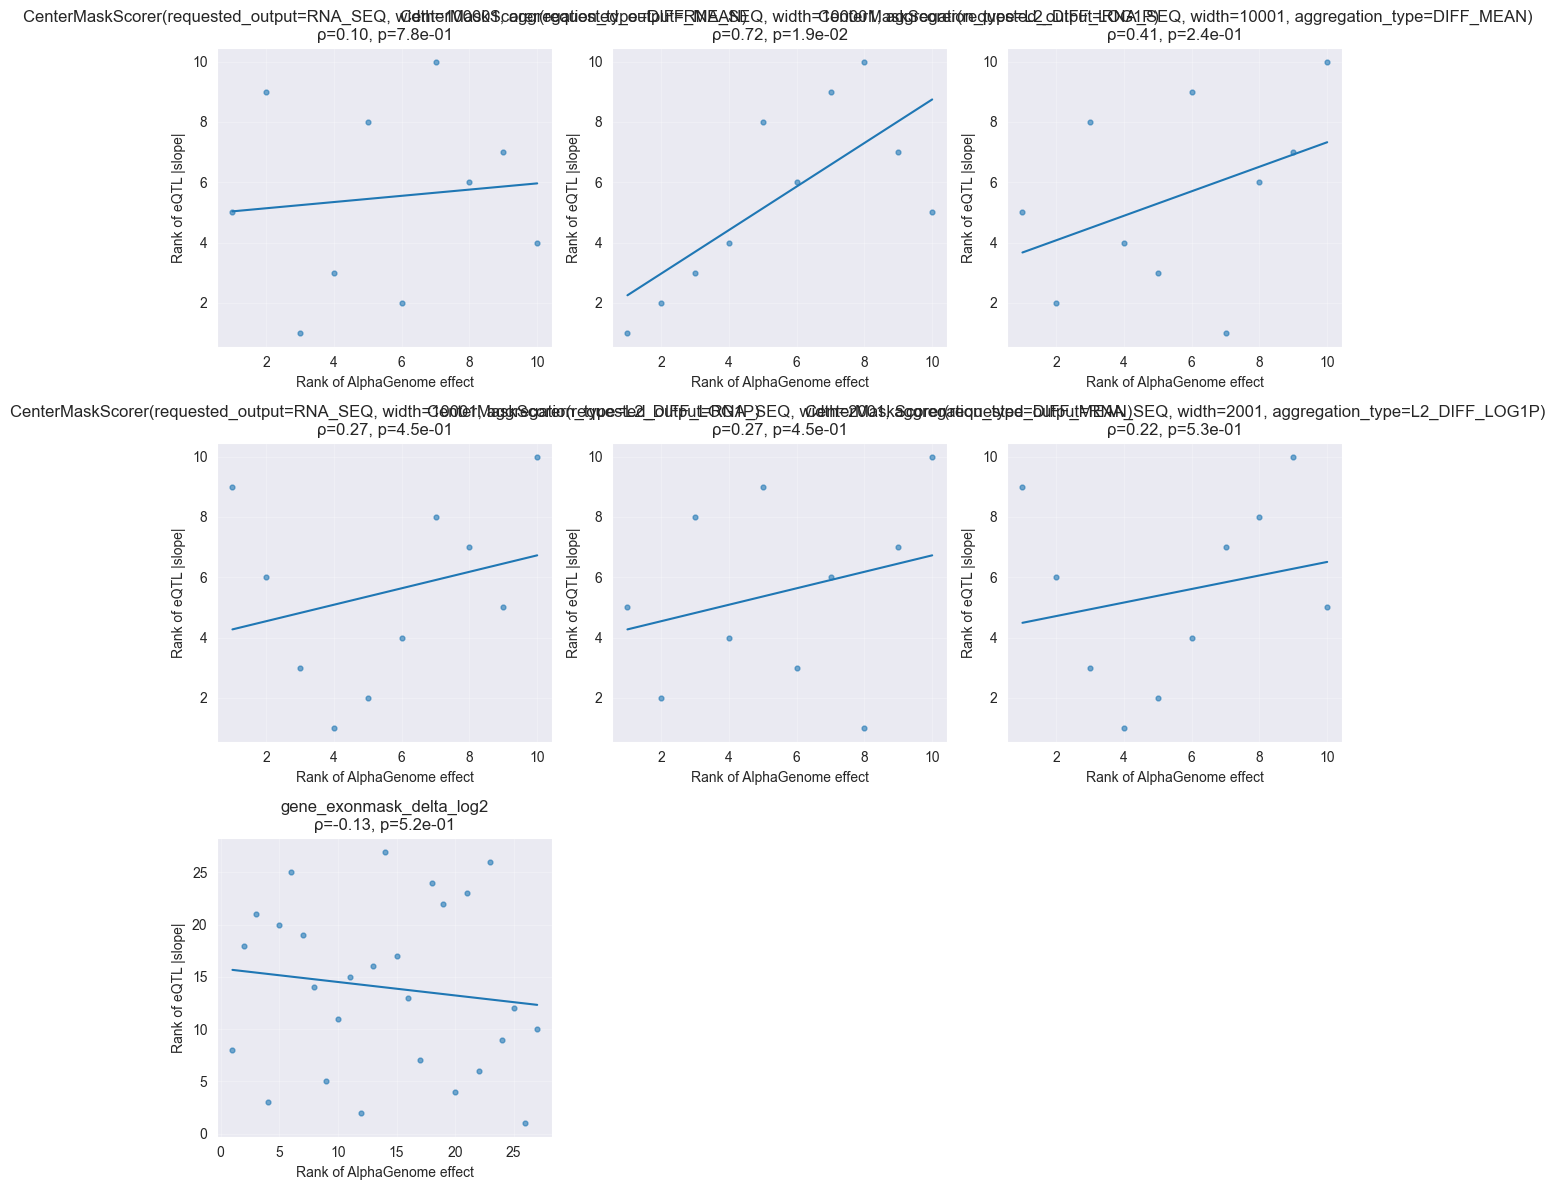

In [8]:
rows_eqtl, per_scorer_eqtl = [], {}

for sc in scorer_order:
    sub = res[res["variant_scorer"] == sc].copy()
    if sub.empty:
        continue

    # Aggregate AlphaGenome effects per gene
    gene_agg = (
        sub.groupby("gene_id", as_index=False)
           .agg(ag_effect=("raw_score", "mean"),
                gene_name=("gene_name", "first"))
    )

    # Merge with eQTL summary
    merged = pd.merge(gene_agg, eqtl_gene, on="gene_id", how="inner")
    merged = merged.dropna(subset=["ag_effect", "mean_abs_slope"])

    if merged.empty:
        continue

    # Pick which eQTL metric to correlate — here: mean_abs_slope
    x = merged["ag_effect"].to_numpy()
    y = merged["mean_abs_slope"].to_numpy()

    pr, pp = pearsonr(x, y)
    sr, sp = spearmanr(x, y)

    rows_eqtl.append({
        "scorer": sc,
        "friendly": friendly(sc),
        "n_genes": merged.shape[0],
        "pearson_r": pr, "pearson_p": pp,
        "spearman_r": sr, "spearman_p": sp
    })
    per_scorer_eqtl[sc] = merged

# Summary table
summary_eqtl = pd.DataFrame(rows_eqtl).sort_values("friendly").reset_index(drop=True)
print(summary_eqtl.loc[:, ["friendly", "n_genes", "pearson_r", "pearson_p", "spearman_r", "spearman_p"]])

# --- Visualization: 3x3 rank-rank scatter plots (Spearman view)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for ax, sc in zip(axes, summary_eqtl["scorer"]):
    d = per_scorer_eqtl[sc]
    xr = d["ag_effect"].rank(method="average")
    yr = d["mean_abs_slope"].rank(method="average")
    sns.regplot(x=xr, y=yr, ax=ax,
                scatter_kws={"s": 12, "alpha": 0.6},
                line_kws={"linewidth": 1.5},
                ci=None)
    row = summary_eqtl[summary_eqtl["scorer"] == sc].iloc[0]
    ax.set_title(f"{row['friendly']}\nρ={row['spearman_r']:.2f}, p={row['spearman_p']:.1e}")
    ax.set_xlabel("Rank of AlphaGenome effect")
    ax.set_ylabel("Rank of eQTL |slope|")
    ax.grid(alpha=0.25)

for j in range(len(summary_eqtl), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

no correlation here either

# Heatmap for all scores and their correlations between different window sizes

Matrix shape: (80425, 7)
Columns: ['center_10.001kb_diff_mean', 'center_10.001kb_l2_log1p', 'center_100.001kb_diff_mean', 'center_100.001kb_l2_log1p', 'center_2.001kb_diff_mean', 'center_2.001kb_l2_log1p', 'gene_exonmask_delta_log2']

Per-scorer coverage (rows = variants):
                            n_nonnull  frac
center_10.001kb_diff_mean       80425   1.0
center_10.001kb_l2_log1p        80425   1.0
center_100.001kb_diff_mean      80425   1.0
center_100.001kb_l2_log1p       80425   1.0
center_2.001kb_diff_mean        80425   1.0
center_2.001kb_l2_log1p         80425   1.0
gene_exonmask_delta_log2        80425   1.0

Pairwise Spearman correlations:
                      scorer_a                    scorer_b      n  \
0    center_10.001kb_diff_mean    center_10.001kb_l2_log1p  80425   
1    center_10.001kb_diff_mean  center_100.001kb_diff_mean  80425   
2    center_10.001kb_diff_mean   center_100.001kb_l2_log1p  80425   
3    center_10.001kb_diff_mean    center_2.001kb_diff_mean  80425

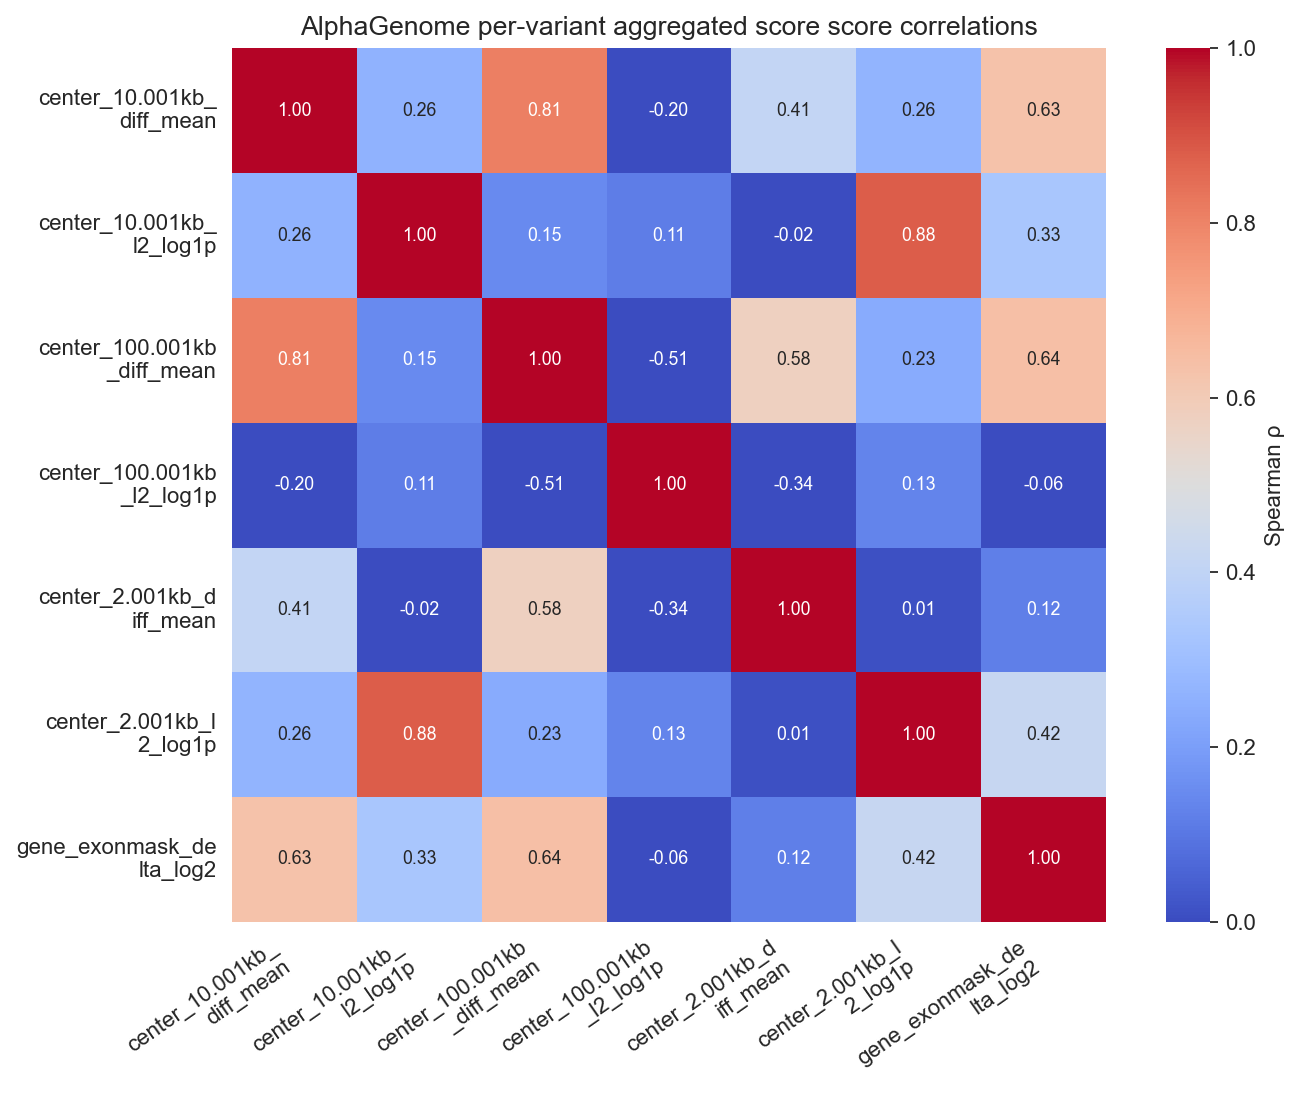

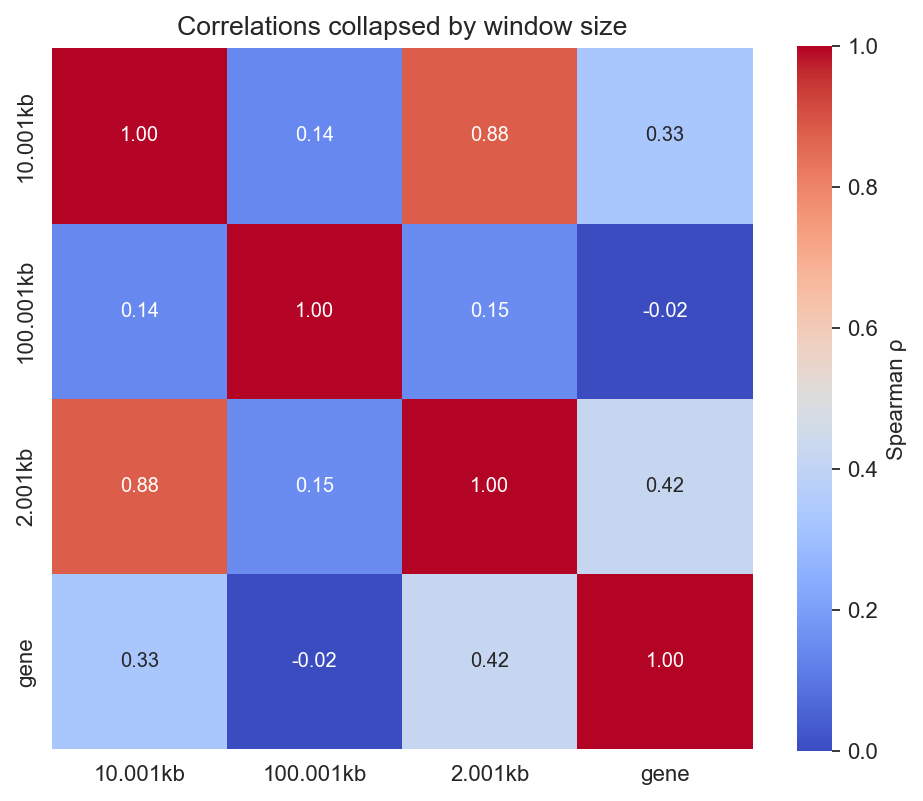

In [11]:
def friendly(name: str) -> str:
    s = str(name)
    for k, v in RENAME_FRIENDLY.items():
        if k in s:
            return v
    return s

def compact_label(col: str) -> str:
    m = re.search(r"CenterMaskScorer.*width=(\d+).*aggregation_type=([^,)]+)", col)
    if m:
        w = int(m.group(1))
        kb = f"{w/1000:.3f}kb".rstrip("0").rstrip(".")
        agg = m.group(2).lower()
        agg = {"diff_mean":"diff_mean", "l2_diff_log1p":"l2_log1p"}.get(agg, agg)
        return f"center_{kb}_{agg}"
    if "gene_exonmask_delta_log2" in col or "GeneMaskLFCScorer" in col:
        return "gene_exonmask_delta_log2"
    return friendly(col)

def parse_iv(s):
    s = str(s)
    m = re.search(r"chr(\w+):(\d+)-(\d+)", s)
    if not m:
        return pd.Series([np.nan, np.nan, np.nan])
    return pd.Series([m.group(1), int(m.group(2)), int(m.group(3))])

ag = pd.read_csv(MUSCLE_SKELETAL_RESULTS, sep="\t", low_memory=False)
iv_src = "scored_interval_str" if "scored_interval_str" in ag.columns else "scored_interval"
ag[["chrom","start","end"]] = ag[iv_src].apply(parse_iv)
ag = ag.dropna(subset=["chrom","start","end","raw_score","variant_scorer"]).copy()
ag["start"] = ag["start"].astype(np.int64)
ag["end"]   = ag["end"].astype(np.int64)
ag = ag[(ag["end"] > ag["start"]) & (ag["start"] >= 0)].copy()
ag = (ag.rename(columns={"chrom":"Chromosome","start":"Start","end":"End"})
        [["Chromosome","Start","End","variant_scorer","raw_score"]]
        .sort_values(["Chromosome","Start","End"], kind="mergesort")
        .reset_index(drop=True))

var = pd.read_csv(VARIANT_FILE, sep="\t", low_memory=False, usecols=["CHROM","POS","variant_id"])
var = var.dropna(subset=["CHROM","POS","variant_id"]).copy()
var["Chromosome"] = var["CHROM"].astype(str).str.replace("^chr", "", regex=True)
var["Start"] = pd.to_numeric(var["POS"], errors="coerce").astype("Int64")
var = var.dropna(subset=["Start"]).copy()
var["Start"] = var["Start"].astype(np.int64)
var = var[var["Start"] >= 0].copy()
var["End"]   = var["Start"] + 1
var = (var[["Chromosome","Start","End","variant_id"]]
        .sort_values(["Chromosome","Start","End"], kind="mergesort")
        .reset_index(drop=True))

def point_in_intervals_join(ag_df, var_df, K=128):
    out = []
    chroms = sorted(set(ag_df["Chromosome"]).intersection(var_df["Chromosome"]))
    for c in chroms:
        a = ag_df.loc[ag_df["Chromosome"]==c, ["Start","End","variant_scorer","raw_score"]].to_numpy()
        v = var_df.loc[var_df["Chromosome"]==c, ["Start","variant_id"]].to_numpy()
        if a.size == 0 or v.size == 0:
            continue
        idx = np.argsort(a[:,0], kind="mergesort")
        a_sorted = a[idx]
        a_st = a_sorted[:,0].astype(np.int64, copy=False)
        pos  = v[:,0].astype(np.int64, copy=False)
        vids = v[:,1]
        right = np.searchsorted(a_st, pos, side="right")
        rows = []
        for i, p in enumerate(pos):
            r = right[i]
            lo = max(0, r-K)
            cand = a_sorted[lo:r]
            if cand.size == 0:
                continue
            mask = (cand[:,0] <= p) & (p < cand[:,1])
            if mask.any():
                sel = cand[mask]
                vid = vids[i]
                for s,e,sc,rs in sel:
                    rows.append((vid, sc, rs))
        if rows:
            out.append(pd.DataFrame(rows, columns=["variant_id","variant_scorer","raw_score"]))
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(columns=["variant_id","variant_scorer","raw_score"])

merged = point_in_intervals_join(ag, var, K=128)
if merged.empty:
    raise RuntimeError("No overlaps between AlphaGenome intervals and variants.")

mv = merged.groupby(["variant_id","variant_scorer"], as_index=False)["raw_score"].mean()
mat = mv.pivot(index="variant_id", columns="variant_scorer", values="raw_score")
mat.columns = [compact_label(c) for c in mat.columns]
mat = mat.sort_index(axis=1).dropna(axis=1, how="all")

print("Matrix shape:", mat.shape)
print("Columns:", list(mat.columns))

if mat.shape[1] < 2 or mat.shape[0] < 3:
    raise RuntimeError("Not enough data to compute correlations.")

cov_tbl = (mat.notna().sum().rename("n_nonnull").to_frame()
           .assign(frac=lambda d: d["n_nonnull"]/mat.shape[0])
           .sort_values("n_nonnull", ascending=False))
print("\nPer-scorer coverage (rows = variants):")
print(cov_tbl)

rows = []
for a, b in combinations(mat.columns, 2):
    sub = mat[[a, b]].dropna()
    n = len(sub)
    if n >= 3:
        rho, p = spearmanr(sub[a], sub[b])
        rows.append((a, b, n, rho, p))
pair_tbl = (pd.DataFrame(rows, columns=["scorer_a","scorer_b","n","spearman_rho","p_value"])
            .sort_values(["scorer_a","scorer_b"]).reset_index(drop=True))
print("\nPairwise Spearman correlations:")
print(pair_tbl)

# ---- HEATMAP (readable axes) ----
corr = mat.corr(method="spearman")
plt.figure(figsize=(9, 7), dpi=160)
ax = sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="coolwarm",
    vmin=0, vmax=1, square=True, cbar_kws={"label":"Spearman ρ"},
    annot_kws={"size":8}
)
xt = ["\n".join(textwrap.wrap(t, width=16)) for t in corr.columns]
yt = ["\n".join(textwrap.wrap(t, width=16)) for t in corr.index]
ax.set_xticklabels(xt, rotation=35, ha="right")
ax.set_yticklabels(yt, rotation=0, va="center")
ax.set_title("AlphaGenome per-variant aggregated score score correlations")
plt.tight_layout()
plt.show()

def window_of(col):
    m = re.search(r"center_([\d\.]+kb)_", col)
    return m.group(1) if m else ("gene" if col.startswith("gene_") else None)

groups = {}
for c in mat.columns:
    w = window_of(c)
    if w: groups.setdefault(w, []).append(c)

if groups:
    mat_win = pd.concat({w: mat[cols].mean(axis=1) for w, cols in groups.items()}, axis=1)
    corr_win = mat_win.corr(method="spearman")
    plt.figure(figsize=(6,5), dpi=160)
    ax2 = sns.heatmap(
        corr_win, annot=True, fmt=".2f", cmap="coolwarm",
        vmin=0, vmax=1, square=True, cbar_kws={"label":"Spearman ρ"},
        annot_kws={"size":9}
    )
    ax2.set_title("Correlations collapsed by window size")
    plt.tight_layout()
    plt.show()

Here we show how different window sizes and aggregation methods capture distinct aspects of regulatory signal around muscle genes.

When scores are compared across window sizes, smaller promoter-centered windows (±2 kb and ±10 kb) are highly correlated, showing that they detect similar local sequence effects close to transcription start sites. but large windows (±100 kb) are only weakly correlated with smaller ones, showing that they integrate over broader chromatin regions and likely dilute specific promoter-driven signals.

Gene-level scores correlate moderately with the narrow-window results, showing that local variant perturbations translate partly—but not entirely—into overall expression-level differences.

The two aggregation strategies: DIFF_MEAN and L2_DIFF_LOG1P, are only moderately correlated, confirming that they measure different properties of predicted regulatory impact—mean directional shifts versus magnitude or variance of change.

So the heatmaps show that AlphaGenome’s window-based scoring is internally consistent for local effects but becomes agree less as spatial context increases. Scale-dependent behavior implies that fine-resolution models best capture promoter and proximal enhancer influences, while large-window scores may reflect broader regulatory or structural features with lower specificity.